In [3]:
import numpy as np
import os, torch
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
from multiprocessing import Pool
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import pandas as pd
from methods.low_level_attributes.image_measures import compute_brightness, compute_saturation, compute_warmth, compute_entropy
from datasets.nsd.nsd_clip import NSDCLIPFeaturesDataset
from datasets.nsd.nsd import NaturalScenesDataset
from methods.high_level_attributes.shift_vectors import load_shift_vector
from sklearn.linear_model import LinearRegression

data_dir = 'data/'
output_dir = 'data/part1_2_outputs'

subject = 5
hemispheres = ['left', 'right']
roi_pairs = [('EBA', 'FBA-1'), ('OFA', 'FFA-1'), ('OPA', 'PPA'), ('OWFA', 'VWFA-1')]

measurements = \
    [f'brightness_{i+1}' for i in range(25)] + \
    [f'saturation_{i+1}' for i in range(25)] + \
    [f'warmth_{i+1}' for i in range(25)] + \
    [f'entropy_{i+1}' for i in range(25)] + \
    [f'depth_{i+1}' for i in range(25)] + \
    [f'gaussian_curvature_{i+1}' for i in range(25)] + \
    [f'surface_normal_1_{i+1}' for i in range(25)] + \
    [f'surface_normal_2_{i+1}' for i in range(25)] + \
    [f'surface_normal_3_{i+1}' for i in range(25)]

f = 'data/ade20k_sun908_nouns.txt'
with open(f, 'r') as file:
    nouns = file.read().splitlines()
nouns = np.array(nouns)

f = 'data/ade20k_sun908_classification.csv'
nouns_df = pd.read_csv(f)

noun_vecs = []
for noun in nouns:
    f = f'data/shift_vectors/categories/{noun}.npy'
    noun_vecs.append(np.load(f))
noun_vecs = np.array(noun_vecs)

categories = {
    'faces': 'faces, eyes, nose, mouth',
    'hands': 'hands, arms, fingers',
    'feet': 'legs, feet, toes',
    'people': 'people, humans, persons',
    'children': 'children, kids, babies',
    'food': 'food, meals, eating', 
    'dessert': 'dessert, sweets, candy',
    'animals': 'animals, creatures, fauna', 
    'plants': 'plants, greenery, flora',
    'water': 'water, rivers, lakes, oceans',
    'earth': 'soil, rocks, wood',
    'sky': 'sky, clouds, flying',
    'furniture': 'furniture, household items',
    'tools': 'tools, equipment, instruments',
    'games': 'toys, games, play',
    'clothing': 'clothing, textiles, garments',
    'electronics': 'electronics, gadgets, devices',
    'vehicles': 'vehicles, transportation, travel',
    'natural outdoors': 'natural areas, landscapes, outdoors',
    'manmade outdoors': 'urban areas, buildings, structures',
    'manmade indoors': 'indoors, rooms, interiors',
    'text': 'text, writing, words, symbols',
}

categories_names = list(categories.keys())

## Gather predictions

### DINO-ViT Predictions

In [4]:
# shape = (n_hemispheres, n_roi_pairs, n_source_images, 2, n_variations)

def load_subject(subject):

    data = np.empty((2, 4, 100, 2, 11))

    for hemisphere_i, hemisphere in enumerate(hemispheres):
        for roi_i, (roi1, roi2) in enumerate(roi_pairs):

            folder = os.path.join(output_dir, f'{subject}_{roi1}_{roi2}_{hemisphere}')
            subfolders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])

            for subfolder_i, subfolder in enumerate(subfolders):
                preds1 = np.load(os.path.join(folder, subfolder, f'dino_vit_preds1.npy'))
                preds2 = np.load(os.path.join(folder, subfolder, f'dino_vit_preds2.npy'))
                data[hemisphere_i, roi_i, subfolder_i, 0] = preds1
                data[hemisphere_i, roi_i, subfolder_i, 1] = preds2

    return data

f = os.path.join(output_dir, 'dino_vit_preds.npy')
if not os.path.exists(f):
    preds_dino = load_subject(subject).astype(np.float32)
    np.save(f, preds_dino)
else:
    preds_dino = np.load(f).astype(np.float32)
    print(preds_dino.shape)

(2, 4, 100, 2, 11)


### CLIP Predictions

In [5]:
# shape = (n_hemispheres, n_roi_pairs, n_source_images, 2, n_variations)

def load_subject(subject):

    data = np.empty((2, 4, 100, 2, 11))

    for hemisphere_i, hemisphere in enumerate(hemispheres):
        for roi_i, (roi1, roi2) in enumerate(roi_pairs):

            folder = os.path.join(output_dir, f'{subject}_{roi1}_{roi2}_{hemisphere}')
            subfolders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])

            for subfolder_i, subfolder in enumerate(subfolders):
                preds1 = np.load(os.path.join(folder, subfolder, f'clip_linear_preds1.npy'))
                preds2 = np.load(os.path.join(folder, subfolder, f'clip_linear_preds2.npy'))
                data[hemisphere_i, roi_i, subfolder_i, 0] = preds1
                data[hemisphere_i, roi_i, subfolder_i, 1] = preds2

    return data

f = os.path.join(output_dir, 'clip_linear_preds.npy')
if not os.path.exists(f):
    preds_clip = load_subject(subject).astype(np.float32)
    np.save(f, preds_clip)
else:
    preds_clip = np.load(f).astype(np.float32)
    print(preds_clip.shape)

(2, 4, 100, 2, 11)


## Gather properties

### Low-level properties

In [6]:
# shape = (n_hemispheres, n_roi_pairs, n_source_images, n_variations, num_measurements)

def resize(measure):
    measure = torch.from_numpy(measure).float().unsqueeze(0)
    measure = torch.nn.functional.interpolate(
        measure,
        size=(5,5),
        mode="bilinear",
        align_corners=False,
    ).squeeze(0)
    measure = measure.numpy()
    return measure

def load_subject(subject):

    data = np.empty((2, 4, 100, 11, len(measurements)))

    for hemisphere_i, hemisphere in enumerate(hemispheres):
        for roi_i, (roi1, roi2) in enumerate(roi_pairs):

            folder = os.path.join(output_dir, f'{subject}_{roi1}_{roi2}_{hemisphere}')
            subfolders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])

            for subfolder_i, subfolder in tqdm(enumerate(subfolders), total=100):

                img_list = np.array([f for f in os.listdir(os.path.join(folder, subfolder)) if f.endswith('.png')])
                img_list_order = np.argsort([int(f.replace('.png', '')) for f in img_list])
                img_list = [os.path.join(folder, subfolder, f) for f in img_list[img_list_order]]

                for img_i, img_f in enumerate(img_list):

                    ms = []
                    
                    img = Image.open(img_f).convert("RGB")

                    # brightness
                    m = compute_brightness(img)
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # saturation
                    m = compute_saturation(img)
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # warmth
                    m = compute_warmth(img)
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # entropy
                    m = compute_entropy(img)
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # depth
                    m = np.load(img_f.replace('.png', '_depth.npy'))
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # gaussian curvature
                    m = np.load(img_f.replace('.png', '_gaussian_curvature.npy'))
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # surface normal
                    m = np.load(img_f.replace('.png', '_surface_normal.npy'))
                    m_ = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m_)
                    m_ = resize(m)[1].reshape(-1).tolist()
                    ms.extend(m_)
                    m_ = resize(m)[2].reshape(-1).tolist()
                    ms.extend(m_)

                    data[hemisphere_i, roi_i, subfolder_i, img_i] = ms

    return data

f = os.path.join(output_dir, 'measurements.npy')
if not os.path.exists(f):
    measurements = load_subject(subject).astype(np.float32)
    np.save(f, measurements)
else:
    measurements = np.load(f).astype(np.float32)
    print(measurements.shape)

(2, 4, 100, 11, 225)


### CLIP features

In [7]:
# shape = (n_hemispheres, n_roi_pairs, n_source_images, n_variations, 1024)

def load_subject(subject):

    data = np.empty((2, 4, 100, 11, 1024))

    for hemisphere_i, hemisphere in enumerate(hemispheres):
        for roi_i, (roi1, roi2) in enumerate(roi_pairs):

            folder = os.path.join(output_dir, f'{subject}_{roi1}_{roi2}_{hemisphere}')
            subfolders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])

            for subfolder_i, subfolder in enumerate(subfolders):

                feats = np.load(os.path.join(folder, subfolder, 'clip_feats.npy'))
                data[hemisphere_i, roi_i, subfolder_i] = feats

    return data

f = os.path.join(output_dir, 'clip_feats.npy')
if not os.path.exists(f):
    clip = load_subject(subject).astype(np.float32)
    np.save(f, clip)
else:
    clip = np.load(f).astype(np.float32)
    print(clip.shape)

(2, 4, 100, 11, 1024)


## Plots

### Visualize manipulation

In [9]:
preds_dino.shape

(2, 4, 100, 2, 11)

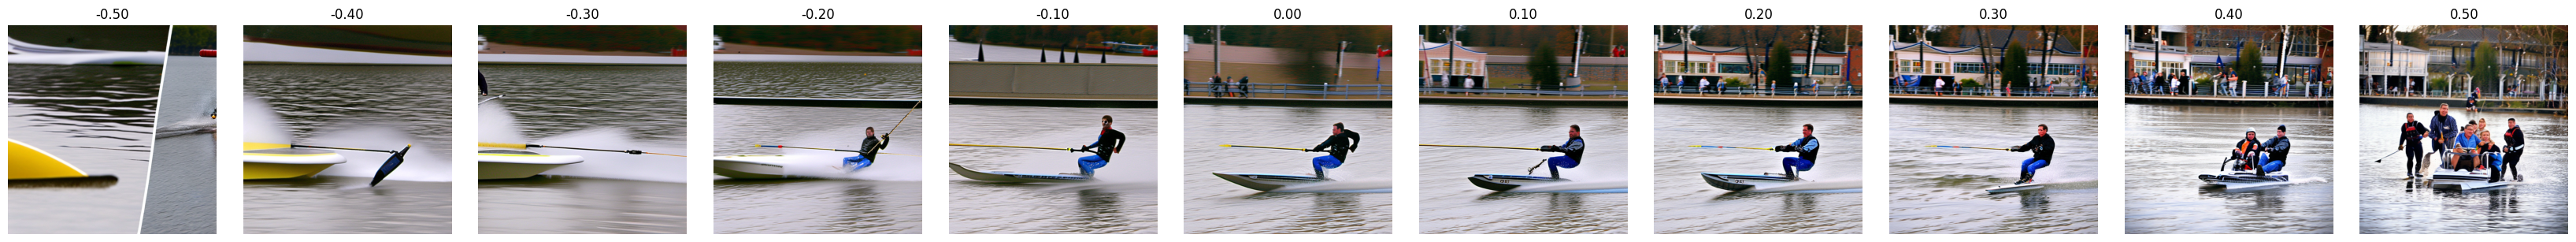

In [78]:
roi_pair = ('OWFA', 'VWFA-1')
hemisphere = 'left'

roi_i = roi_pairs.index(roi_pair)
hemisphere_i = hemispheres.index(hemisphere)

idx = np.random.choice(range(100), 1)[0]
x_range = np.linspace(-0.5, 0.5, 11)

folder = os.path.join(output_dir, f'{subject}_{roi_pair[0]}_{roi_pair[1]}_{hemisphere}')
subfolder = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])[idx]

img_list = np.array([f for f in os.listdir(os.path.join(folder, subfolder)) if f.endswith('.png')])
img_list_order = np.argsort([int(f.replace('.png', '')) for f in img_list])
img_list = [os.path.join(folder, subfolder, f) for f in img_list[img_list_order]]

dino_p = preds_dino[hemisphere_i, roi_i, idx]
clip_p = preds_clip[hemisphere_i, roi_i, idx]

f, axes = plt.subplots(1, 11, figsize=(33, 3))
for i, img_f in enumerate(img_list):
    img = Image.open(img_f)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'{x_range[i]:.2f}')
plt.tight_layout()
plt.show()

### Effect on predicted responses

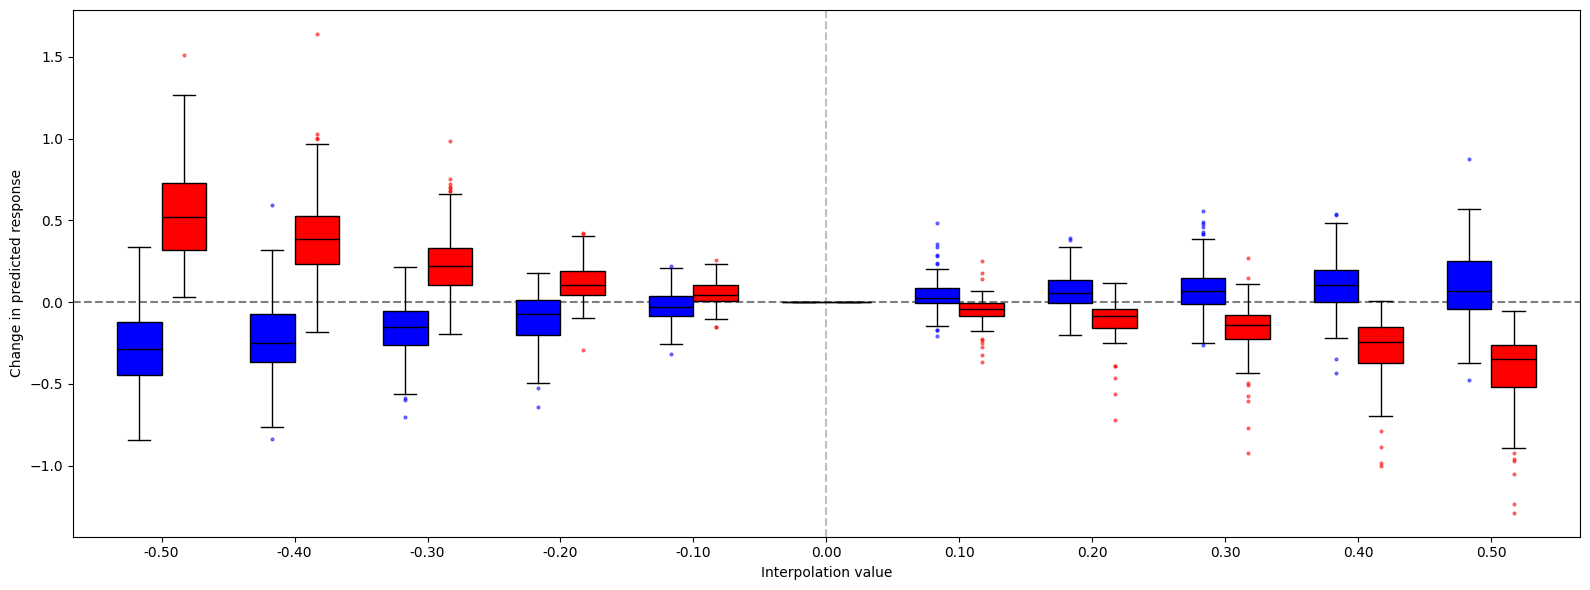

In [79]:
roi_pair = ('OWFA', 'VWFA-1')
hemisphere = 'left'

roi_i = roi_pairs.index(roi_pair)
hemisphere_i = hemispheres.index(hemisphere)

plt.figure(figsize=(16, 6))
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)

shifts = [-0.5, 0.5]
alphas = np.linspace(-15, 15, 11)

dino_p = preds_dino[hemisphere_i, roi_i, :]
dino_p = dino_p - dino_p[:, :, [5]]

plt.boxplot(
    dino_p[:,0], positions=alphas+shifts[0], widths=1, showfliers=True, patch_artist=True, 
    boxprops=dict(facecolor='blue'), 
    medianprops=dict(color='black'), 
    whiskerprops=dict(color='black'), 
    capprops=dict(color='black'), 
    flierprops=dict(marker='o', markerfacecolor='blue', markeredgecolor='blue', markersize=2, alpha=0.5), 
)
plt.boxplot(
    dino_p[:,1], positions=alphas+shifts[1], widths=1, showfliers=True, patch_artist=True, 
    boxprops=dict(facecolor='red'), 
    medianprops=dict(color='black'), 
    whiskerprops=dict(color='black'), 
    capprops=dict(color='black'), 
    flierprops=dict(marker='o', markerfacecolor='red', markeredgecolor='red', markersize=2, alpha=0.5), 
)

plt.xlim(-17, 17)
plt.xticks(alphas, [f'{a:.2f}' for a in np.linspace(-0.5, 0.5, 11)])
plt.xlabel('Interpolation value')
plt.ylabel('Change in predicted response')
plt.tight_layout()
plt.show()